In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import linalg

from tutorial_utils import *

/home/kleeman/miniconda3/envs/dev/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Evaluating Uncertainty

Let's say you've built a model which is good at predicting some things but there are difficult scenarios for which it cannot be expected to produce good estimates. As an example, imagine trying to use the last 10 days of daily temperature to predict future temperatures. A model might be pretty good at predicting tomorrow's temperature, less good three days out, and we wouldn't expect it to have any skill 3 months out. The same thing might happen with a spatial model, we'd expect predictions to get worse the further the prediction location is from data used to train the model.

When it comes time to evaluate the performance of a model like this we might want both good accuracy _and_ reliable uncertainty. Having reliable uncertainty then lets the user decide how much to trust a prediction. Imagine a user is using the output from our model to make a decision. Perhaps they're hosting an event and plan to cancel the event if the temperature gets too high. If the model forecasts high temperature, the next thing they'll want to know is how confident it is. If the forecast is "_definitely_ high temperature" they'll probably want to cancel, but it it's "_maybe_ high temperature" they may want to wait till closer to the event.

The point being, that when uncertainty factors into decision making we need to not only evaluate the accuracy of a model, but also the reliability of the uncertainty estimates.

We'll start with a simple univariate case to motivate the problem. Let's say we have a model which is predicting some quantity, $y$. Instead of just returning the model's best guess, it returns a distribution of possible values for $y$. This distribution represents the uncertainty. For this example let's say the model provides a normal distribution with mean and variance, $\hat{y} \sim \mathcal{N}\left(\mu, \sigma^2\right)$. Here's a possible single realization of this example problem,

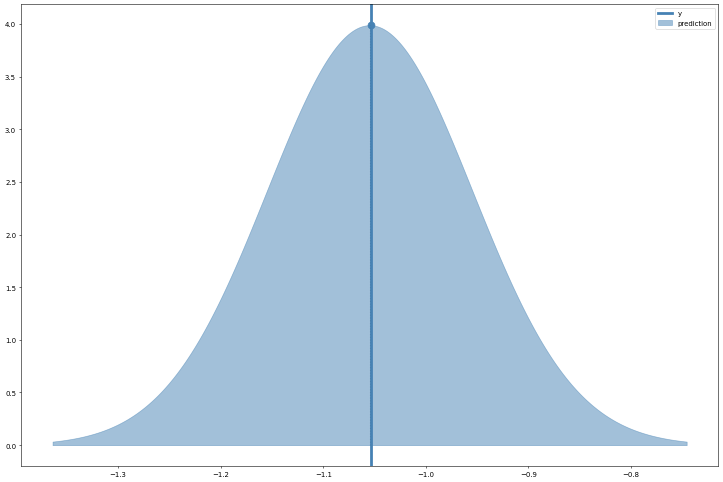

In [2]:
def one_random_sample(predictive_sigma=0.1):
    y = np.random.normal()
    mu = y + predictive_sigma * np.random.normal()
    predictive_dist = stats.norm(loc=mu, scale=predictive_sigma)
    return y, predictive_dist

y, dist = one_random_sample()
lo = dist.ppf(0.001)
hi = dist.ppf(0.999)
mu = dist.mean()
xs = np.linspace(lo, hi, 501)
plt.fill_between(xs, dist.pdf(xs), np.zeros(xs.size),
                 alpha=0.5,
                 color='steelblue',
                 label="prediction")
plt.plot([mu, mu], [0, dist.pdf(mu)], color='black', alpha=0.5, ls=":")
ylim = plt.ylim()
plt.plot([y, y], ylim, color='steelblue', lw=4, label="y")
plt.scatter(y, dist.pdf(y), color='steelblue', s=100)
plt.ylim(ylim)
plt.legend()

You can re-evaluate that cell to see more scenarios. Just by looking at where the true value, $y$, falls relative to the predictive distribution we can subjectively say that the predictive distribution is reasonable, but how can we actually quantify that?

With only a single truth and prediction we _might_ be able to place a probability that the truth came from the predictive distribution, but we can't exactly make any claims about the predictive distribution being reliable in general. For that we'd need more samples. With a large number of samples, we can compare the samples to the predicted distribution,

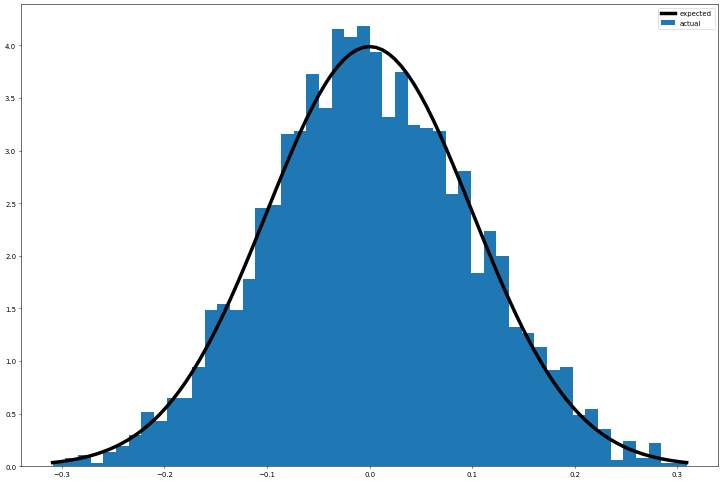

In [3]:
def random_errors_and_sds():
    samples = [one_random_sample() for i in range(3000)]
    errors = [y - dist.mean() for y, dist in samples]
    # assume the predicted variance is the same for all
    sd = samples[0][1].std()
    return errors, stats.norm(loc=0, scale=sd)

errors, dist = random_errors_and_sds()

lo = dist.ppf(0.001)
hi = dist.ppf(0.999)
xs = np.linspace(lo, hi, 101)
plt.plot(xs, dist.pdf(xs), color="black", lw=5, label="expected")
plt.hist(errors, bins=np.linspace(lo, hi, 51),
         density=True, label="actual")
plt.legend()

Looks about right. A few details to point out here though. In this simplified example we've made it so the predicted distribution is exactly the same for every data point. This lets us draw the "Expected" PDF on the plot above. However, in reality we'd hope the model would be assigning different uncertainty to different points. One option to still produce plots like this when the model's predicted variance changes would be to normalize the errors. So first divide the error by the predicted standard deviation, then produce a similar plot,

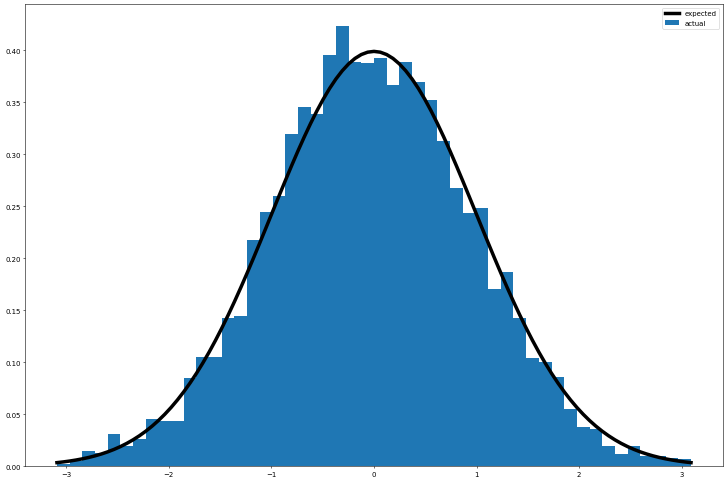

In [4]:
def normalized_random_errors():
    # notice we're now varying the predicted standard deviation
    samples = [one_random_sample(predictive_sigma=np.random.gamma(1))
               for i in range(5000)]
    normalized_errors = [(y - dist.mean()) / dist.std()
                         for y, dist in samples]
    return normalized_errors, stats.norm(loc=0, scale=1)

errors, dist = normalized_random_errors()

lo = dist.ppf(0.001)
hi = dist.ppf(0.999)
xs = np.linspace(lo, hi, 101)
plt.plot(xs, dist.pdf(xs), color="black", lw=5, label="expected")
plt.hist(errors, bins=np.linspace(lo, hi, 51),
         density=True, label="actual")
plt.legend()

The only real difference here is the change in the scale of the x-axis. The point here is that _if the predictive distribution is Gaussian_ then normalizing the errors first let's you compare a large number of errors to their predictive distribution to get a sense of how reliable the provided uncertainty is. This normalization trick works for univariate normal distributions, but there's a more general approach,

## Reliability Diagrams

There's a very helpful property, the [probability integral transform](https://en.wikipedia.org/wiki/Probability_integral_transform), which states that `data values that are modeled as being random variables from any given continuous distribution can be converted to random variables having a standard uniform distribution`. [This stack overflow conversation](https://stats.stackexchange.com/a/161649) has some good intuitive descriptions of why that's true.

We can convince ourselves it is in fact true using simulations. We can pick an arbitrary distribution, draw samples, compute the CDF of each sample and then plot the distribution of the resulting quantiles. Below let's visually confirm the probability integral transform. To do so we'll need to pick a continuous one dimensional probability distribution. Here are a few good choices,
```
stats.gamma(1)
stats.chi2(df=5)
stats.lognorm(1)
```
of course, you could also use the normal distribution, but we're about to use that heavily so try something different here. Once you've picked a distribution you can draw random samples from it using the `.rvs(k)` function which will draw $k$ random variables from the distribution.

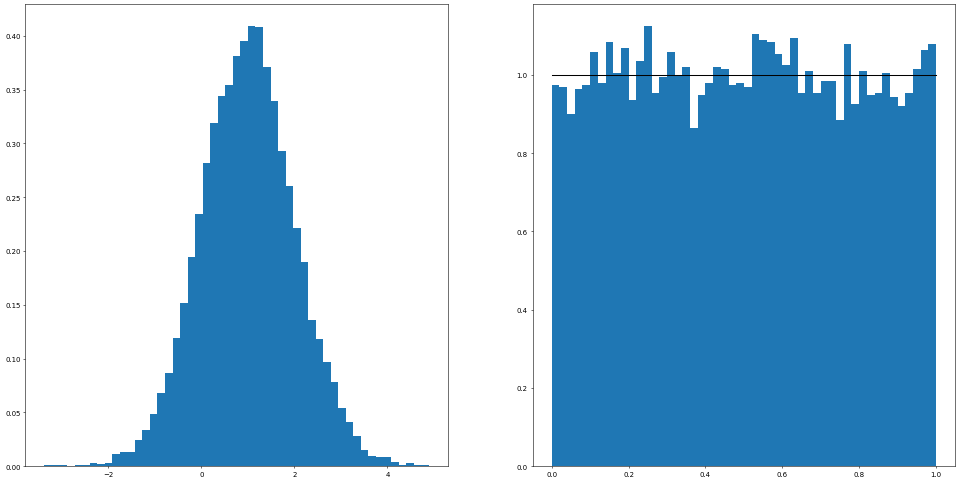

In [9]:
# YOUR CODE HERE
# Pick any continous distribution
dist = stats.norm(1)
samples = dist.rvs(10000)
cdfs = dist.cdf(samples)
# draw a large number (10k?) of random samples from the distribution
#   samples = 

# evaluate the CDF at each sample
#   cdfs = 

fig, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].hist(samples, bins=51, density=True)
axes[1].hist(cdfs, bins=np.linspace(0., 1., 51), density=True)
axes[1].plot([0, 1], [1, 1], color='black')

You should see the histogram of random samples from your distribution on the left, and then distribution of the CDF evaluated at each sample on the right. This right plot showing the distribution of percentiles ($\mbox{CDF}(x)$) is called a reliability diagram.

Reliablity diagrams can be a good way of diagnosing under or over confidence in a model. For example, if the actual errors were larger than the models reported variance you'd see a reliability diagram which looks like this:

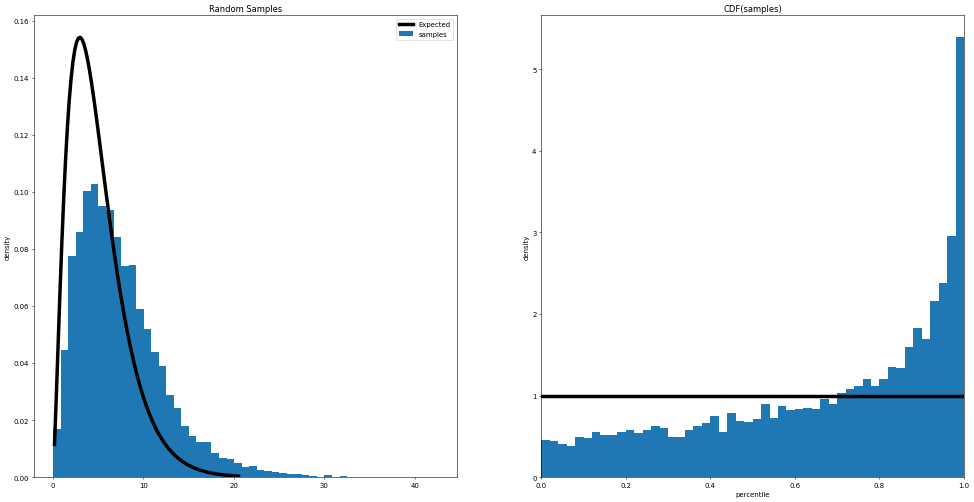

In [14]:
dist = stats.chi2(df=5)
samples = dist.rvs(10000)
plot_samples_and_reliability(1.5 * samples, dist)

Both of these plots (left: the sample distribution compared to the expected distribution and right: the reliability diagram) tell the same story, the actual samples are larger than what was expected. We can see this from the reliability diagram because we see the sample distribution (blue) is larger than the expected (black line) for the higher percentiles which tells us that more samples fall in that percentile that you'd expect. At the same time there were too few data points in the lower percentile.

While the PDF (left) and reliability diagram (right) contain the same information, the reliablity diagram (CDF) is a bit easier to interpret and, perhaps most significantly, it can be interpreted the same regardless of the underlying distribution and regardless of whether that distribution was different for each sample point.

Here's another example of a mismatch between the samples and the predicted distribution in which we've shrunk the size of the samples

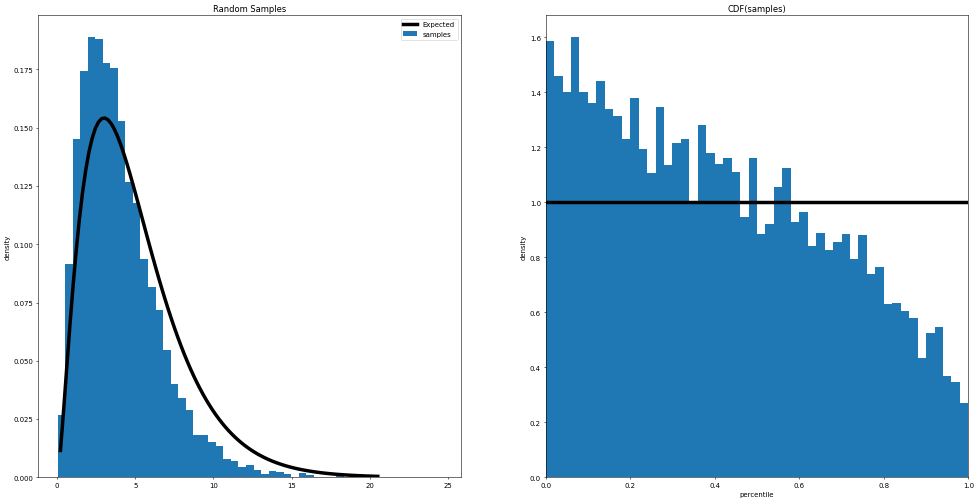

In [15]:
dist = stats.chi2(df=5)
samples = dist.rvs(10000)
plot_samples_and_reliability(0.8 * samples, dist)

Now we see that there are more samples falling in the lower quantiles than we'd expect: so the model was under confident, it _could_ have reported smaller variances.

## Reliability Diagrams for Multivariate Normal Distributions

We can use reliability diagrams to assess the quality of uncertainy estimates when the predictive distribution is a continuous one dimensional distribution. As we've seen in previous tutorials, Gaussian processes are capable of providing predictive covariance (joint distribution) between data points not just their individual (marginal) variance. In otherwords, instead of a single measurement and a one dimensional predictive distribution, we have a vector of measurements and a multivariate normal predictive distribution. How can we asses the reliability of the entire covariance, not just the marginal (one dimensional) variance?

Say we have a single truth vector, $y$, and a predictive distribution,
$$
\mathbf{\hat{y}} \sim \mathcal{N}\left(\mu, \Sigma\right)
$$
because we're now dealing with a multivariate distribution the one dimensional concept of a CDF doesn't directly apply. One option which [extends the concept of a CDF to multivariate normals](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Cumulative_distribution_function) is to consider the Mahalnobis distance, $r^T \Sigma^{-1} r$, with $r = y - \mu$, which will follow a chi squared distribution.

To see why, consider samples drawn from a known multivariate normal distribution,
$$
r \sim \mathcal{N}\left(0, \Sigma\right)
$$
Assuming $\Sigma$ is invertible, we can find $L$ such that $\Sigma = L L^T$. Then by multiplying through by $L^{-1}$ we get,
$$
\begin{align}
z &= L^{-1} r \\
 &\sim \mathcal{N}\left(0, L^{-1} \Sigma L^{-T}\right) \\
 &\sim \mathcal{N}\left(0, I\right)
\end{align}
$$
the resulting random variable $z$ can be thought of as the normalized the residuals. By normalzing the result is a number of independent identically distributed standard normal variables so we know the sum of squares should follow a chi squared distribution with $n$ degrees of freedom,
$$
\begin{align}
r^T \Sigma^{-1} r &= z^T z \\
  &=\sum_i^n z_i^2 \\
  &\sim \chi^2(n)
\end{align}
$$

This gives us a way of testing if random samples were drawn from a multivariate normal distribution with covariance $\Sigma$:
- Compute the errors, $r = y - \hat{y}$
- Normalize, $z = L^{-1} r$
- Sum Squares, $z^T z$
- Compute chi squared CDF, $\mbox{CDF}_{\chi^2(n)}(z^T z)$
- Repeat for many random samples, compare to uniform distribution.

Let's do so below. First we need to generate a bunch of random samples from an arbitrary multivariate distribution,

In [16]:
MEAS_NOISE = 1e-2
S = random_covariance(n=10, meas_noise=MEAS_NOISE)
samples = random_samples(S, k=5000)
print(samples)

[[-1.7117931  -0.0413571  -1.26081657 ... -1.60686764  1.87621527
   0.36841605]
 [ 0.89732156 -1.84158099 -0.63854232 ...  0.97089186  0.28558553
  -0.16314446]
 [-0.45902298 -0.58779073 -1.45250327 ... -0.82105644 -0.39201945
  -0.00335004]
 ...
 [ 1.18010651  0.75112293  0.88927987 ...  1.68396249  0.31218206
   0.23541729]
 [-0.60938022  2.2388455   0.95077071 ... -1.53508918 -1.10267985
   0.45781761]
 [-0.15237513 -0.91800416 -0.35290923 ... -0.73463542 -0.28551248
  -0.41241693]]


Then we can normalize and evaluate the chi squared cdf for each of the normalized sum squared errors,

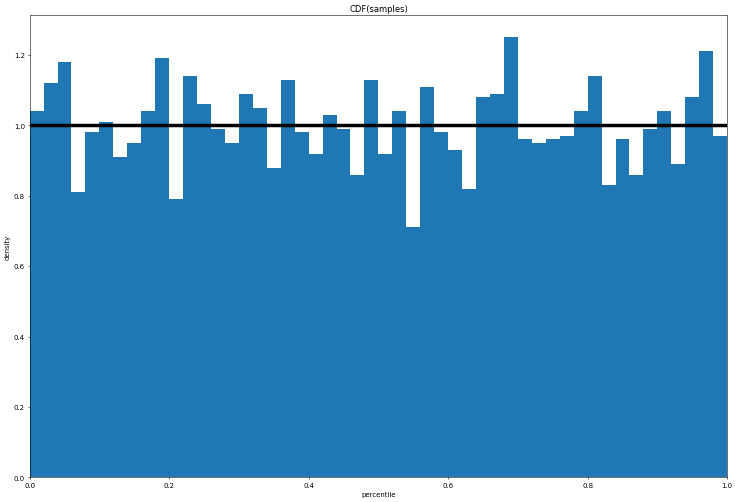

In [17]:
def chi_squared_cdf(residuals, cov, df=None):
    if df is None:
        df = cov.shape[0]
    # in case cov is near singular, add a nugget
    chol = linalg.cholesky(cov + 1e-12 * np.eye(cov.shape[0]), lower=True)
    normalized = np.linalg.solve(chol, residuals)
    chi2_samples = np.sum(np.square(normalized), axis=0)
    return stats.chi2(df=df).cdf(chi2_samples)


def mvn_cdf(cov, df=None):
    def cdf(x):
        return chi_squared_cdf(x, cov, df=df)
    return cdf

reliability_diagram(samples, mvn_cdf(S))

We can see that the resulting distribution does in fact look like samples from a uniform distribution.

# KS Test
Looking at a reliability diagram is usually a good way to gain intuition around how reliable uncertainty estimates are, you can determine if a model is under or over confident, diagnose bias etc ... but what if all you care about is a measure of how reliable a model's uncertainty is? One option is to use the Kolmogorov Smirnov (KS) test. The test works by comparing samples from some distribution with the expected CDF. In this case we have uniformly distributed percentiles, so we can compute the empirical (sample based) CDF to the expected CDF (uniform) and then form a measure of how similar the two are,

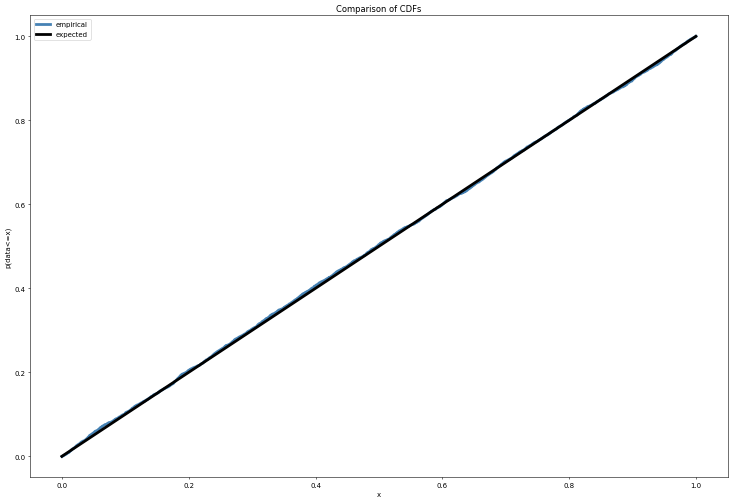

In [18]:

def plot_cdfs(percentiles):
    percentiles = np.sort(percentiles)
    cumulative = np.arange(samples.shape[1]) / samples.shape[1]
    plt.plot(percentiles, cumulative, color='steelblue',
             lw=4, label="empirical")
    plt.plot(cumulative, cumulative, color='black',
             lw=4, label="expected")
    plt.xlabel("x")
    plt.ylabel("p(data<=x)")
    plt.title("Comparison of CDFs")
    plt.legend()
    
plot_cdfs(chi_squared_cdf(samples, S))

In this case the expected and actual CDFs align, but what if we shrink the predictive covariance,

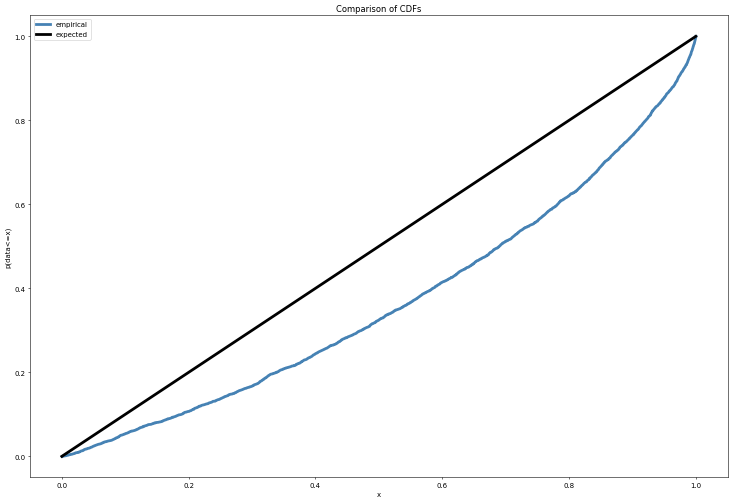

In [19]:
plot_cdfs(chi_squared_cdf(samples, 0.8 * S))

The KS statistic measures the largest difference between the two distributions, in this case we'd measure,

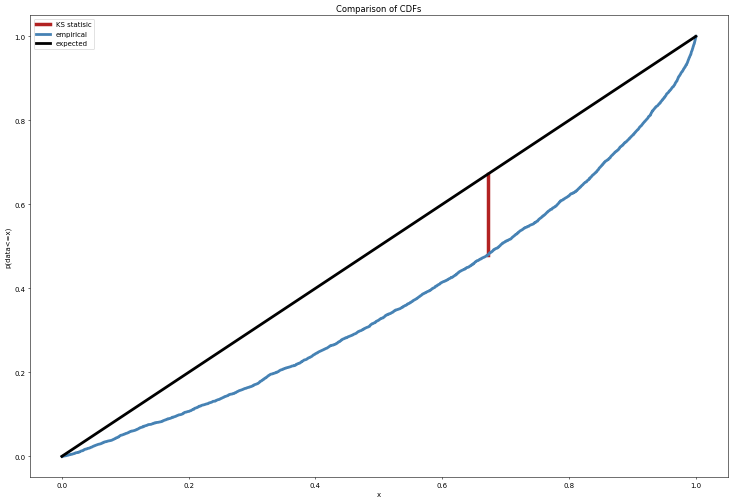

In [20]:
def empirical_cdf(data):
    sorted_data = sorted(data)
    n = len(data)
    
    def ecdf(x):
        count = 0
        for value in sorted_data:
            if value <= x:
                count += 1
        return count / n
    
    return np.vectorize(ecdf)

expected = np.arange(samples.shape[1]) / samples.shape[1]
bad_cdfs = chi_squared_cdf(samples, 0.8 * S)
ecdf = empirical_cdf(bad_cdfs)
diff = ecdf(expected) - expected

max_ind = np.argmax(np.abs(diff))
worst_x = expected[max_ind]
plt.plot([worst_x, worst_x],
         [ecdf(worst_x), expected[max_ind]],
         color='firebrick', lw=5,
         label='KS statisic'
        )
plot_cdfs(chi_squared_cdf(samples, 0.8 * S))

There's a tool in scipy to compute this statisic as well as a p-value

In [21]:
ks_result = stats.kstest(bad_cdfs, "uniform")
print("KS statistic: ", ks_result.statistic)
print("KS   p-value: ", ks_result.pvalue)

KS statistic:  0.19289582137286487
KS   p-value:  1.9620312773745685e-163


The statistic here tells us that there's a large (about 0.2) difference between the CDFs, and the p-value tells us it is extremely unlikely that the samples came from a uniform distribution. If we try the KS tests using samples which are uniform,

In [22]:
ks_result = stats.kstest(chi_squared_cdf(samples, S), "uniform")
print("KS statistic: ", ks_result.statistic)
print("KS   p-value: ", ks_result.pvalue)

KS statistic:  0.008192317243543551
KS   p-value:  0.8876449265398186


then we can see the statistic is much lower and the p-value tells us it's relatively likely the samples came from a uniform distribution.

# Bias vs Uncertainty

These plots are also capable of identifying bias in predictions, here's a bunch of different plots in which we've introduced bias to the random samples, or scaled the random samples:

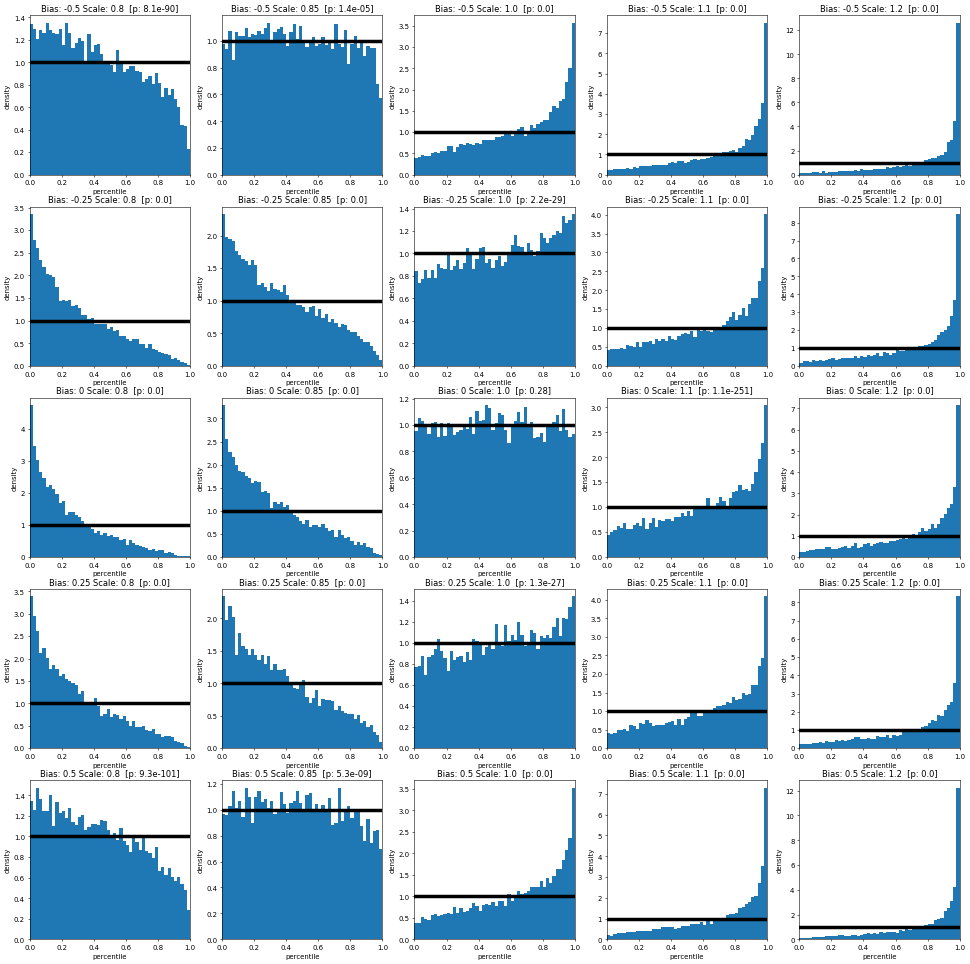

In [23]:
mvn_samples = np.random.normal(size=(10, 10000))

bias = [-0.5, -0.25, 0, 0.25, 0.5]
scale = [0.8, 0.85, 1.0, 1.1, 1.2]
fig, axes = plt.subplots(len(bias), len(scale), figsize=(24, 24))

chi2_dist = stats.chi2(df=mvn_samples.shape[0])

for (i, j), ax in np.ndenumerate(axes):
    sum_squares = np.sum(np.square(bias[i] + scale[j] * mvn_samples), axis=0)
    p = stats.kstest(chi2_dist.cdf(sum_squares), "uniform").pvalue
    reliability_diagram(sum_squares, chi2_dist.cdf, ax=ax)
    ax.set_title(f"Bias: {bias[i]} Scale: {scale[j]}  [p: {p:.2}]")

You can see that any one of the error sources (bias or improper scale) show up on the reliability diagram. That said, if you add a bias and compensate by decreasing the scale it (top and bottom rows, second column) it can be tough to tell there was a mis-modelling. In that case we see there are still fewer measeurements falling in the higher percentiles and the p value from the KS test still gives a strong indicator that there was mis-modeling.

# Summary
If we string all these tools together we now have a process for taking a model and a bunch of data and measuring the reliability of the uncertainty estimates. In general the process consists of:
- Use the model to produce a predictive distribution for some true measurements, $y_i \sim \mathcal{D}_i$
- Compute the CDF of the measurements relative to the proposed distribution, $p_i = \mbox{CDF}_{\mathcal{D}_i}(y_i)$
- Repeating this for a large number of samples, to get a distribution of percentiles, $p = \left\{p_0, \ldots, p_n\right\}$
- Producing a reliability diagram, or running the KS test, to decide if the percentiles are uniformly distributed.

## [BONUS] Is this model reliable?

Here's some example data produced from a hypothetical model. The model is asked to make predictions, $\hat{y}_i \mbox{model}(x_i)$ at some locations $x_i$. Those are compared to the truth to get errors, $\mbox{error}_i = y_i - \hat{y}_i$. Each of these predictions is multivariate, so $y_i \in \mathbb{R}^{n_i}$, and the size of the problem has changed at each iteration (so $n_i$ is different for every $i$). Along with the mean prediction the model has provided a covariance matrix, $\Sigma_i$.

In [ ]:
data = generate_tutorial_5_example_model_data()
error_0, cov_0 = data[0]
print("Example error: ", error_0)
print("Example cov  : ", cov_0)

Let's use these errors and reported uncertainties to decide if the model's reported covariances are reliable,

In [ ]:
# Compute the percentile for a given multivariate error vector
# for a mean zero multivariate normal distribution with the
# provided covariance matrix
#
# Given:
#   error : np.ndarray (n, 1)
#   cov   : np.ndarray (n, n)
# Returns:
#   percentile : float
def compute_percentile(error, cov):
    # YOUR CODE HERE
    # return scalar

test_percentile = compute_percentile(np.ones((3, 1)), np.eye(3))
# the output should be a scalar
assert(np.array(test_percentile).size == 1)
assert(np.abs(test_percentile - 0.608) < 1e-3)

percentiles = [np.array(compute_percentile(error, cov)).item()
               for error, cov in data]
plt.hist(percentiles, bins=11, density=True)

# Compute the p value for the hypothesis that the samples were
# drawn from the predictive distributions proposed by the model
#
# Given:
#   percentiles: np.ndarray (k)
# Returns:
#   pvalue : scalar
def compute_pvalue(percentiles):
    # YOUR CODE HERE
    # return scalar

test_value = compute_pvalue(np.zeros(10000))
assert(np.array(test_value).size == 1)
assert(np.abs(test_value) < 1e-8)
assert(compute_pvalue(np.random.uniform(size=10000)) > 0.001)

compute_pvalue(percentiles)

print(f"Probability the model is reliable: {p_value}")